In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [16]:
def clean_strings(val):
    if isinstance(val, str):
        clean = val.replace('<', '')
        clean = clean.replace('>', '')
        try:
            return(float(clean))
        except ValueError:
            return(np.nan)
    elif isinstance(val, float) or isinstance(val, int):
        return(float(val))
    else:
        return(np.nan)

In [17]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/mali_meta/for_viz.csv')
val_cols = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml']
main_data[val_cols] = main_data[val_cols].applymap(clean_strings)
main_data[val_cols] = main_data[val_cols].applymap(np.log10)
main_data = main_data[['participant_id', 'HRP2_pg_ml', 'LDH_Pan_pg_ml',
                       'LDH_Pv_pg_ml', 'CRP_ng_ml', 'timepoint_days', 'date_dif',
                       'drug', 'age_yrs', 'RDT_pos', 'HRP2_result',
                       'LDH_Pan_result', 'LDH_Pv_result']]
pos_vals = main_data.loc[main_data['RDT_pos'] == 1]
pos_vals.loc[pos_vals['HRP2_pg_ml'] < 1.4, 'RDT_pos'] = 2
neg_vals = main_data.loc[main_data['RDT_pos'] != 1]
main_data = pd.concat([pos_vals, neg_vals])
rdt_vars = {'RDT_pos': {0: 'green', 1: 'red', 2: 'yellow', np.nan: 'black'}}
main_data.replace(rdt_vars, inplace=True)
main_data.head()

,participant_id,HRP2_pg_ml,LDH_Pan_pg_ml,LDH_Pv_pg_ml,CRP_ng_ml,timepoint_days,date_dif,drug,age_yrs,RDT_pos,HRP2_result,LDH_Pan_result,LDH_Pv_result
8,MV-15-301-F,3.040179,2.276232,0.740852,2.290452,58.0,58.0,NaN,32.35,red,positive,positive,negative
12,MV-15-301-F,3.701119,1.158664,0.367356,1.426988,72.0,72.0,NaN,32.39,red,positive,negative,negative
26,MV-15-302-k,2.228631,1.751356,0.556821,3.074721,58.0,58.0,NaN,43.36,red,positive,positive,negative
30,MV-15-302-k,4.151123,2.684441,0.685464,3.680981,72.0,72.0,NaN,43.40,red,positive,positive,negative
84,MV-15-307-A,4.147469,2.378016,0.852785,3.187214,72.0,72.0,NaN,41.40,red,positive,positive,negative


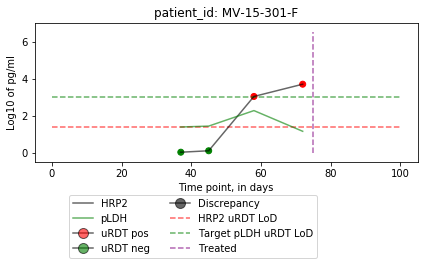

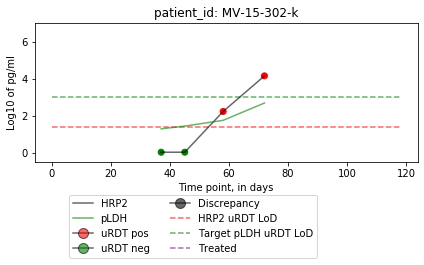

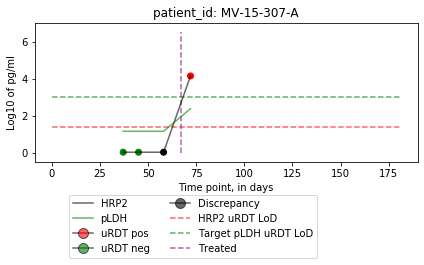

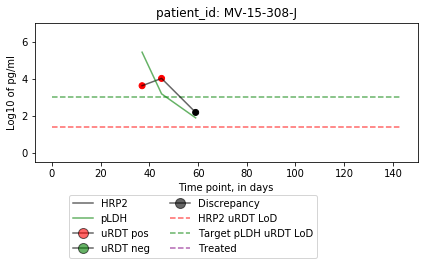

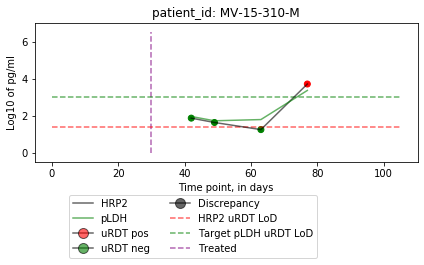

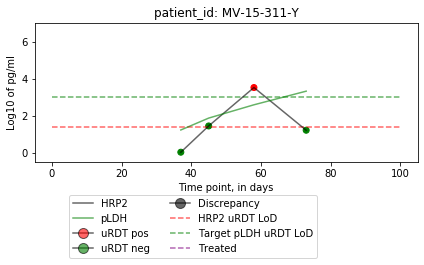

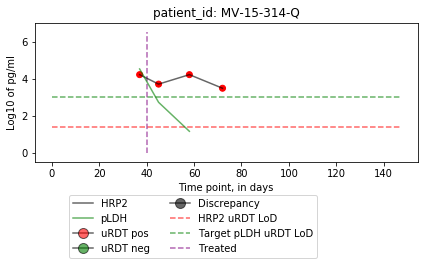

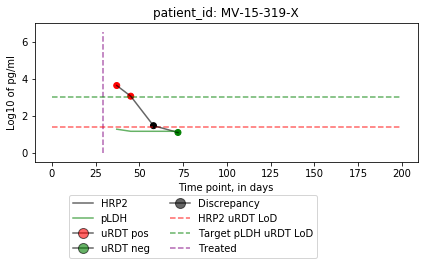

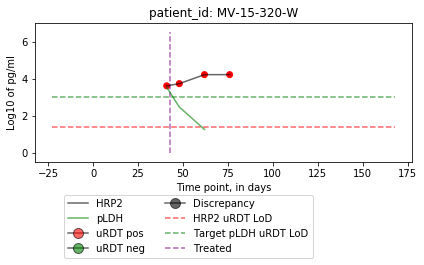

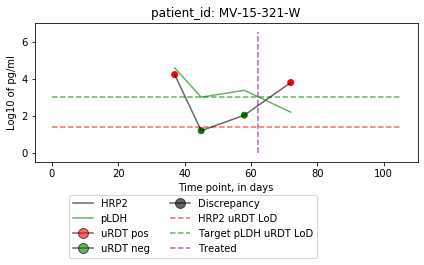

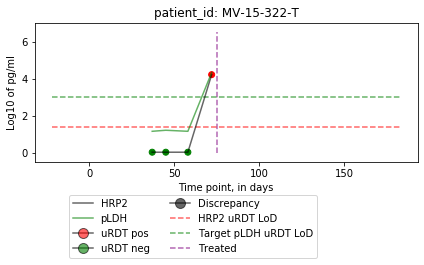

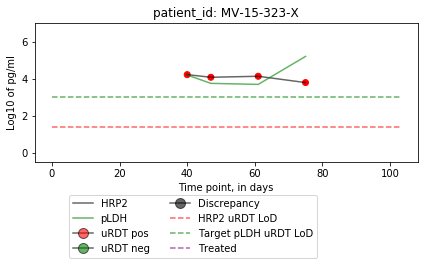

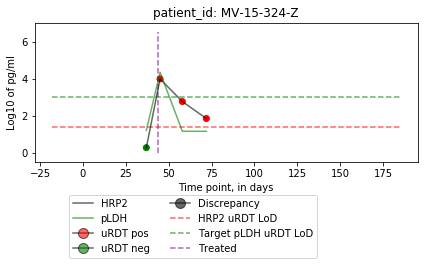

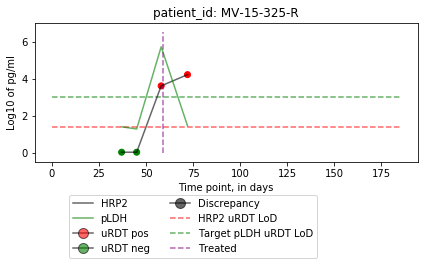

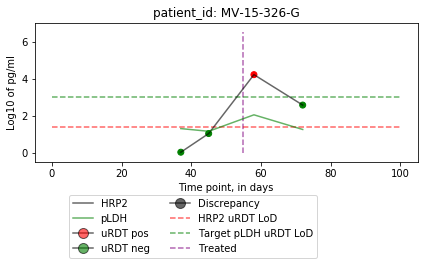

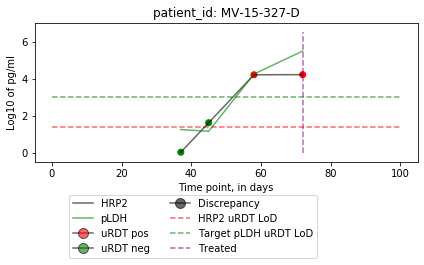

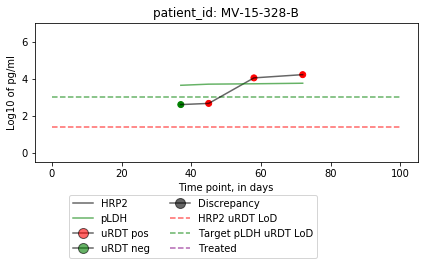

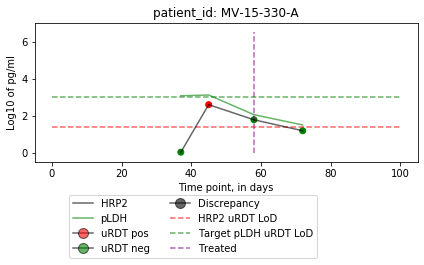

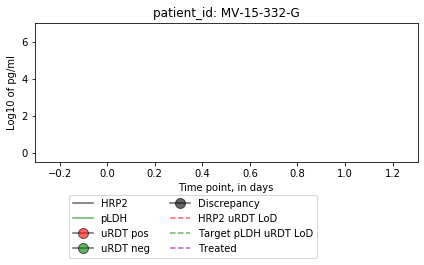

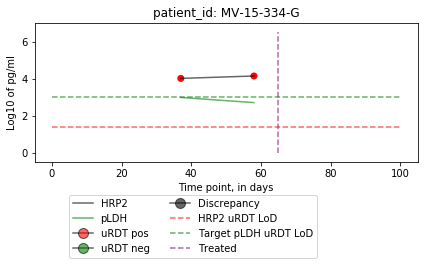

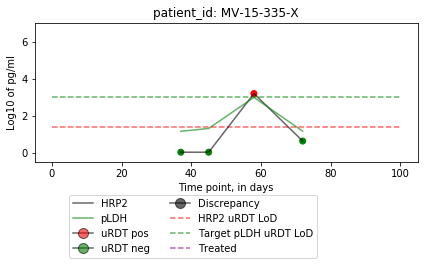

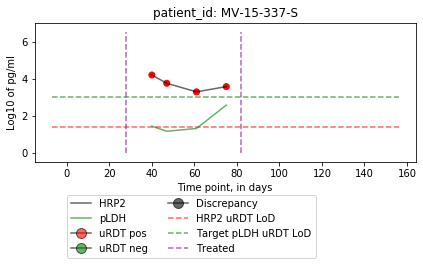

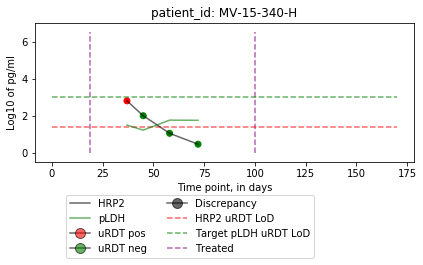

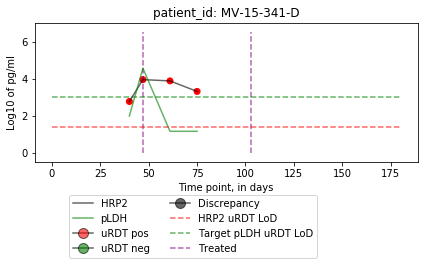

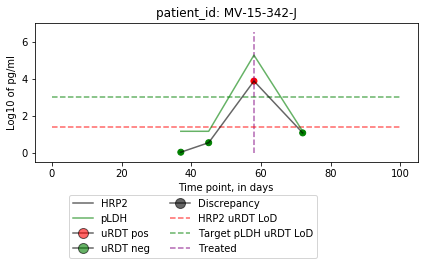

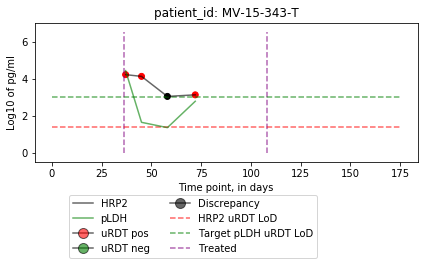

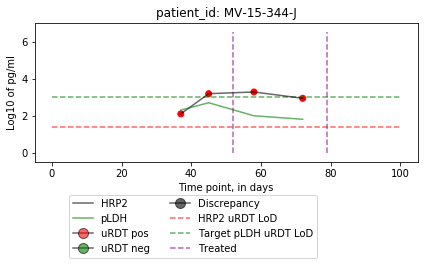

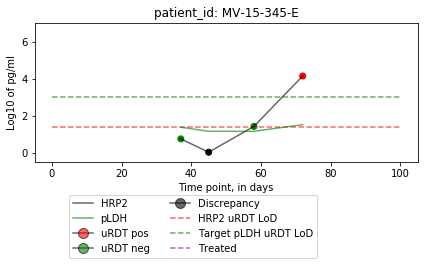

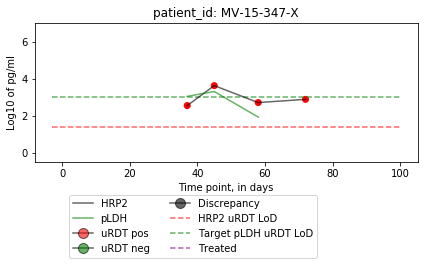

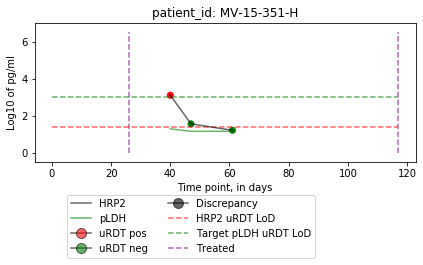

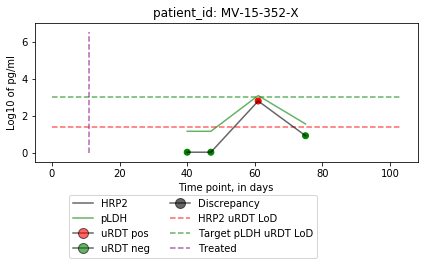

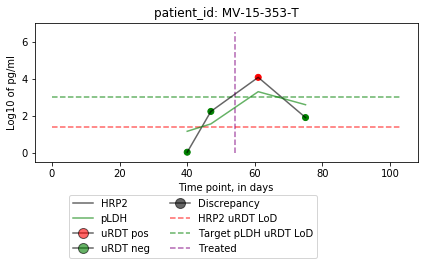

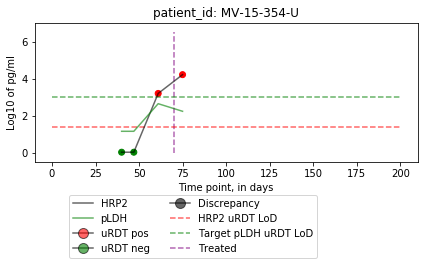

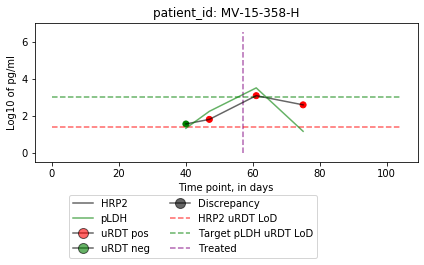

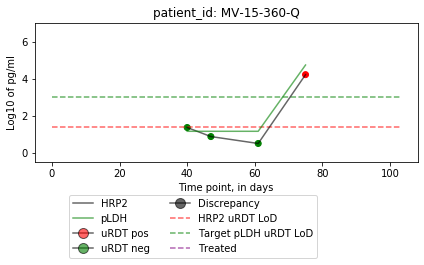

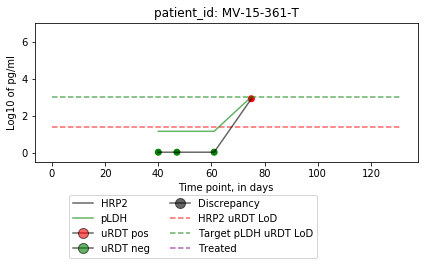

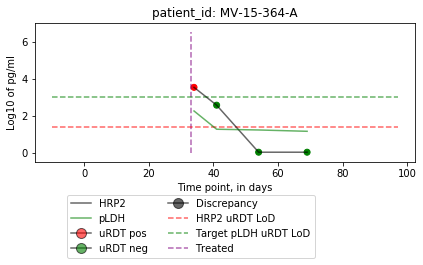

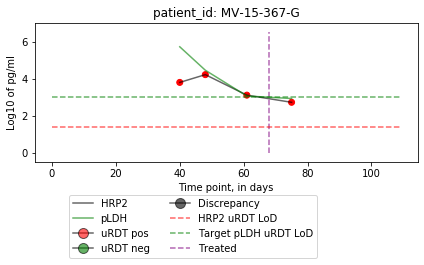

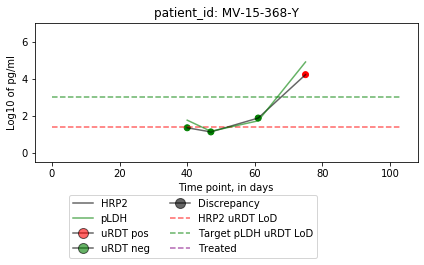

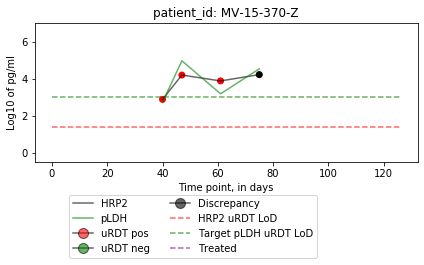

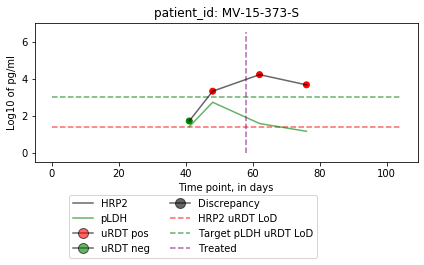

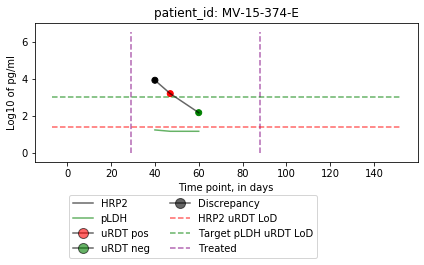

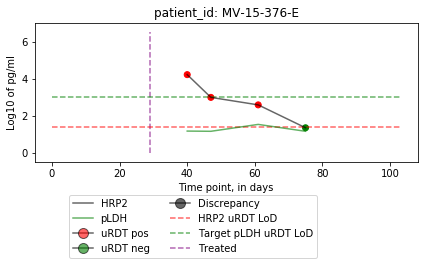

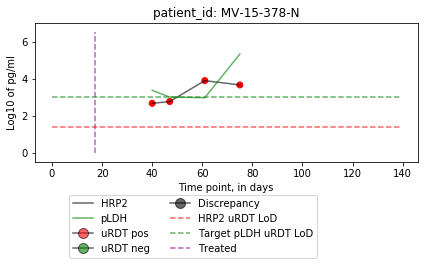

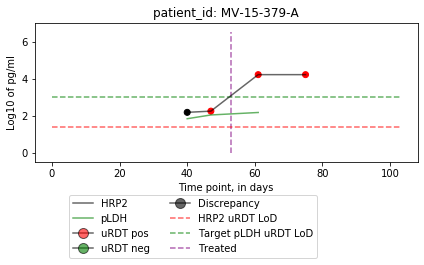

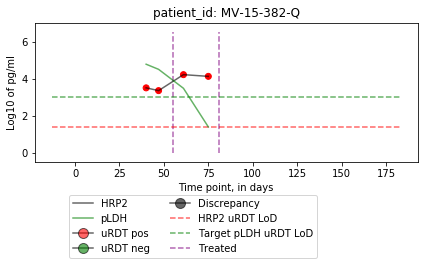

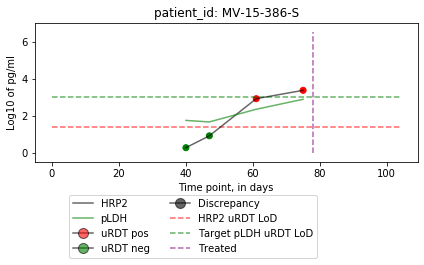

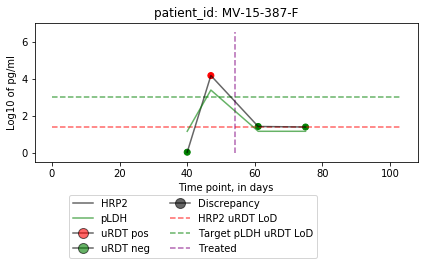

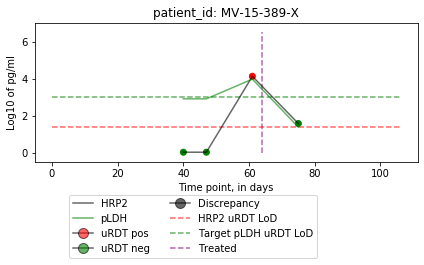

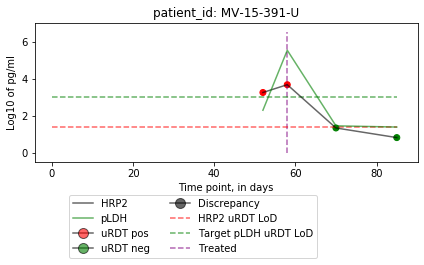

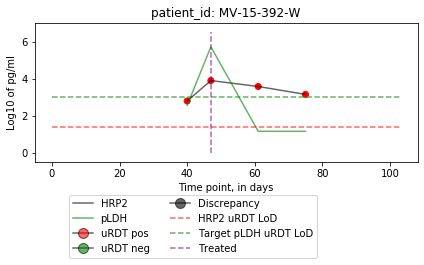

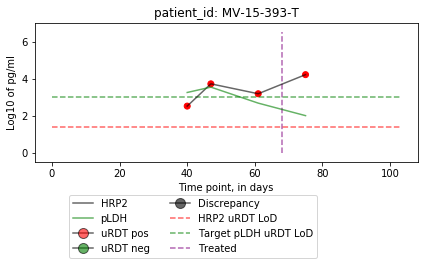

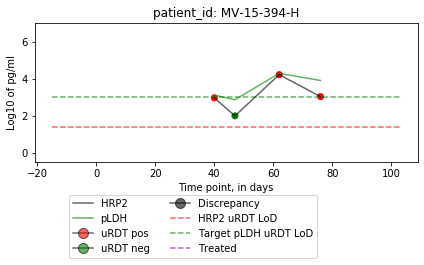

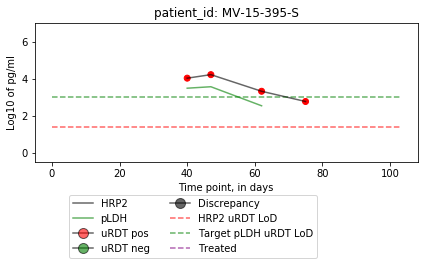

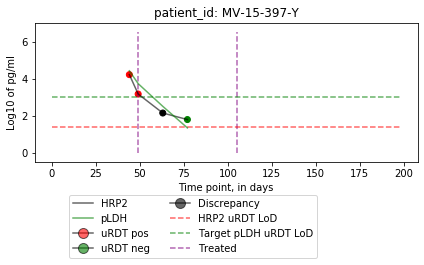

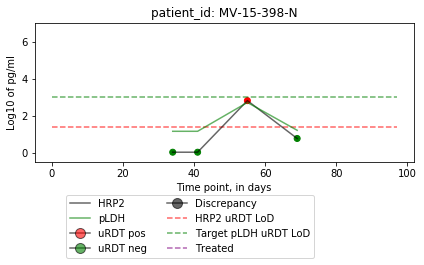

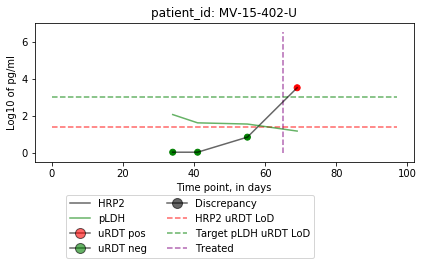

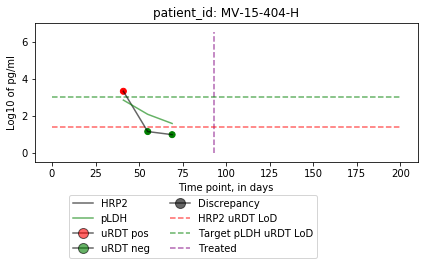

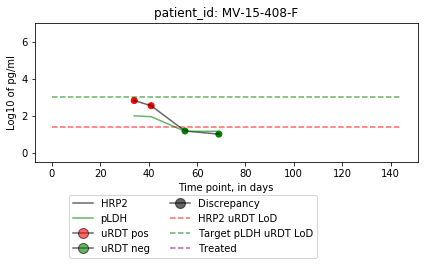

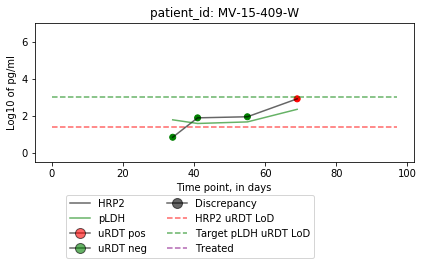

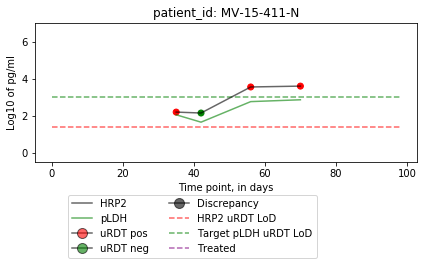

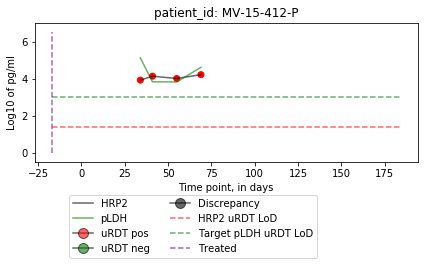

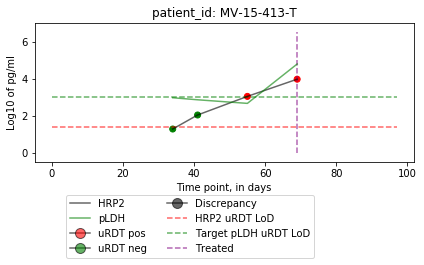

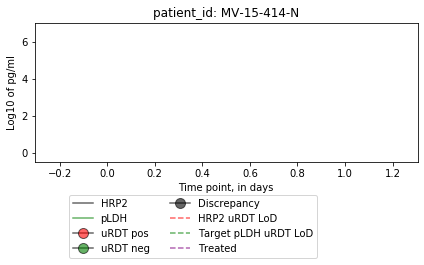

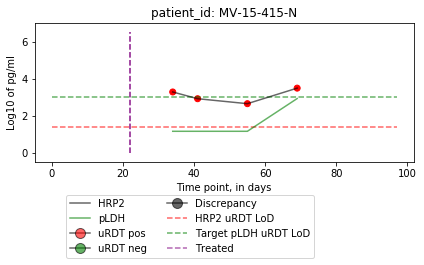

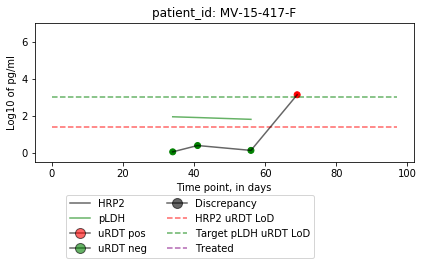

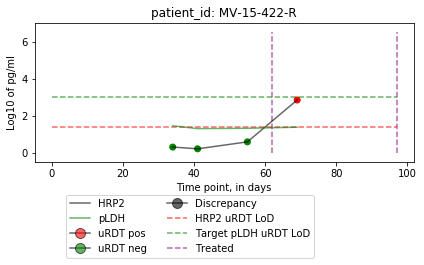

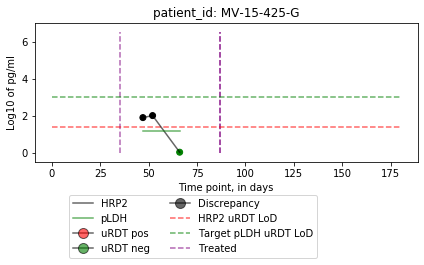

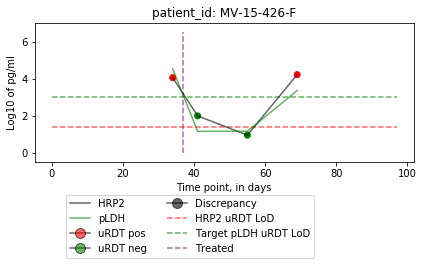

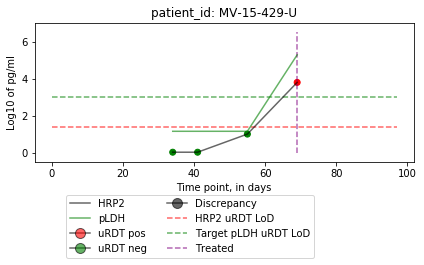

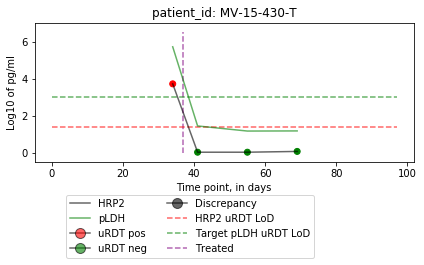

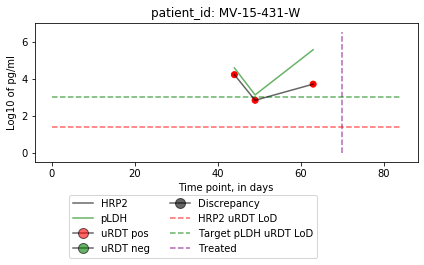

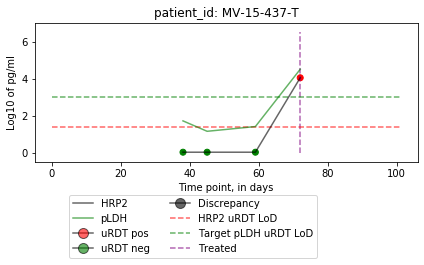

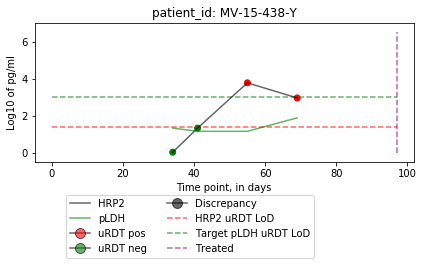

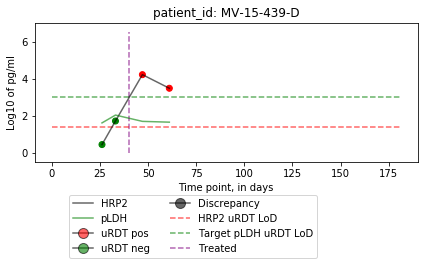

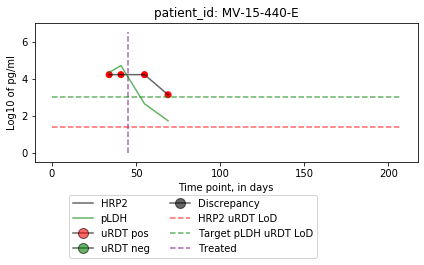

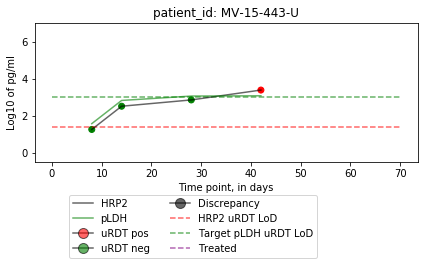

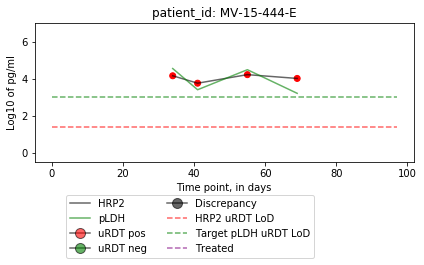

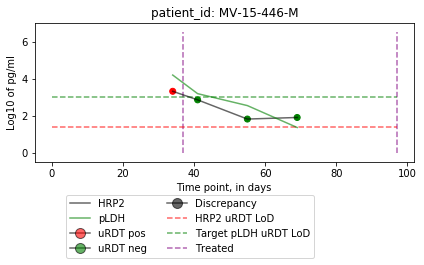

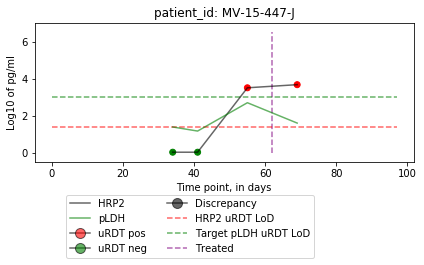

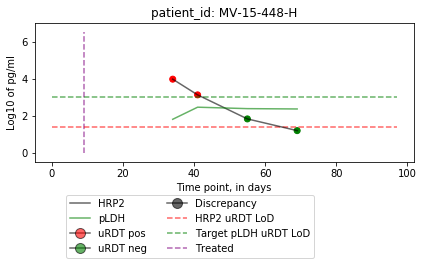

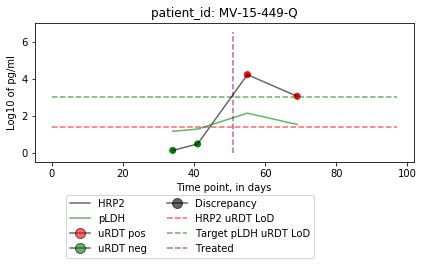

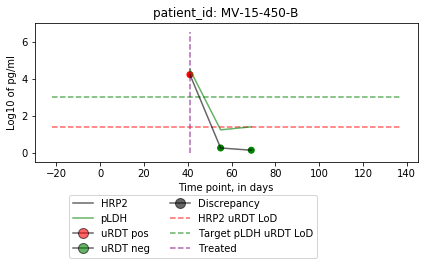

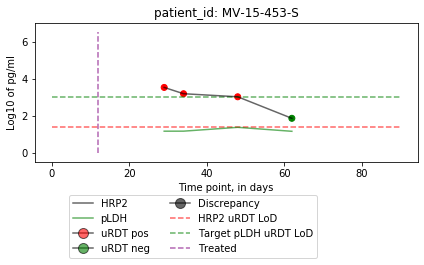

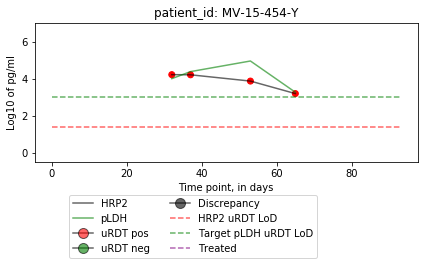

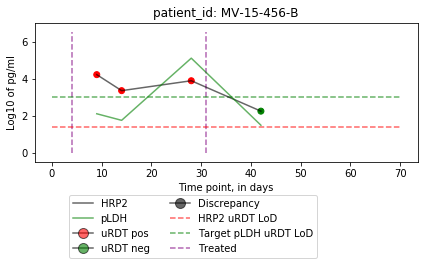

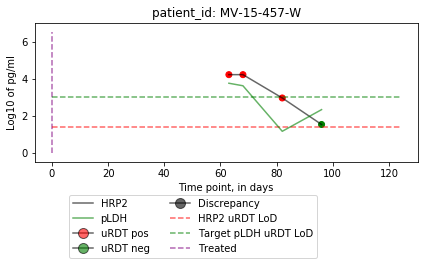

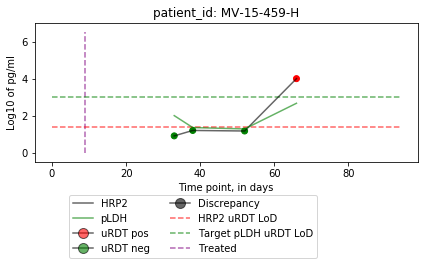

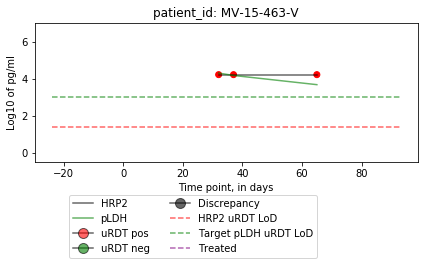

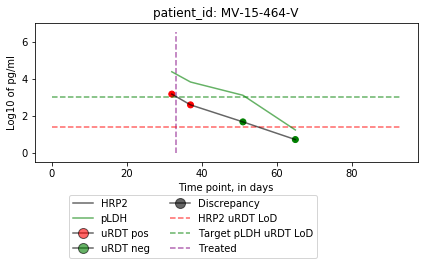

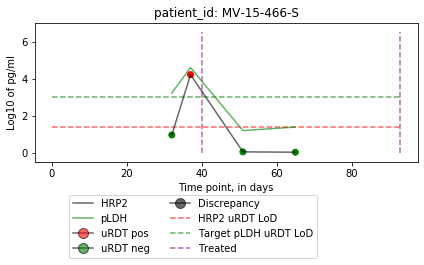

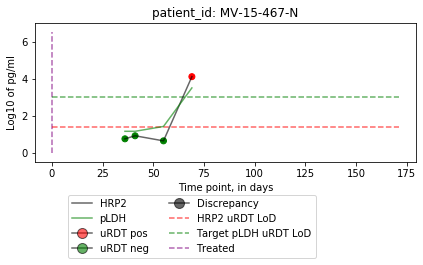

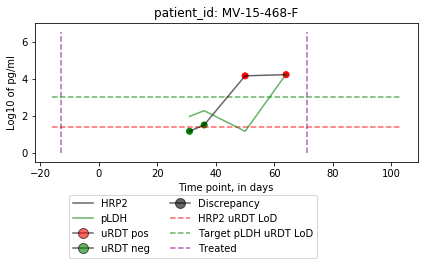

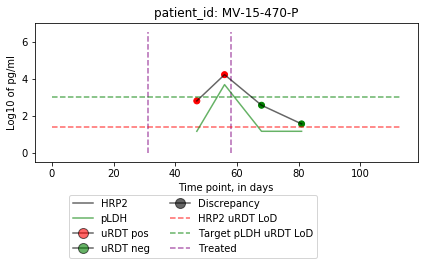

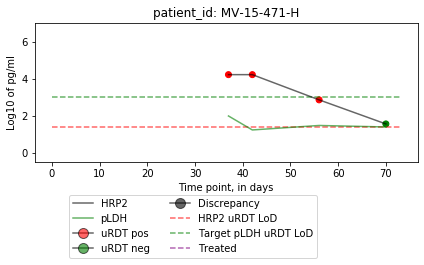

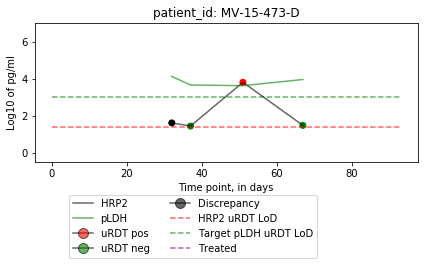

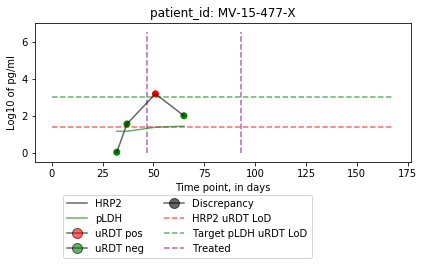

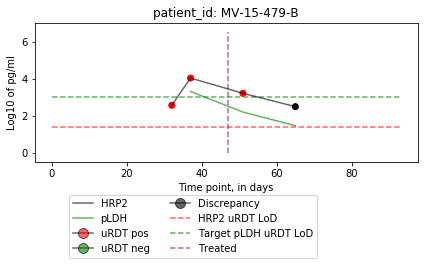

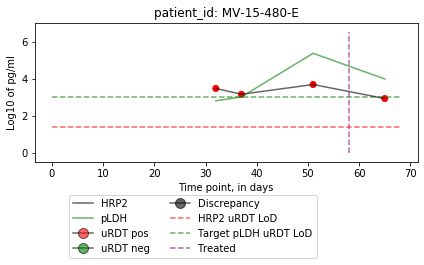

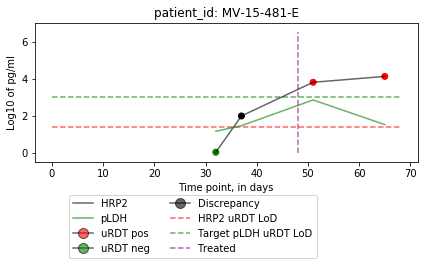

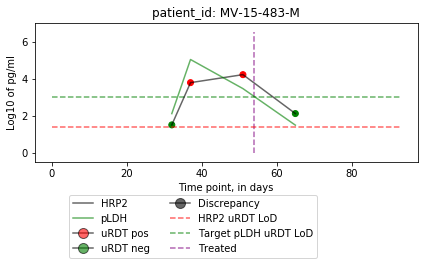

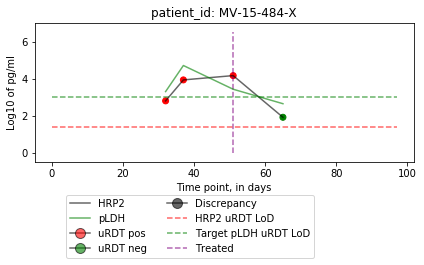

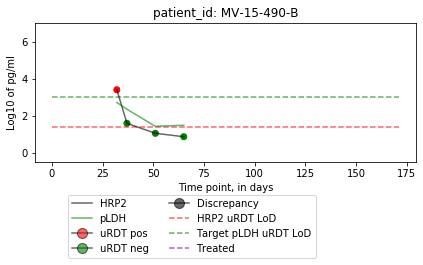

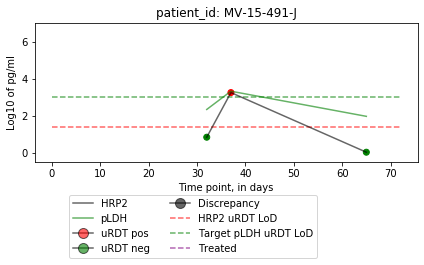

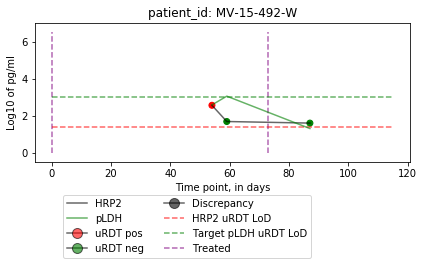

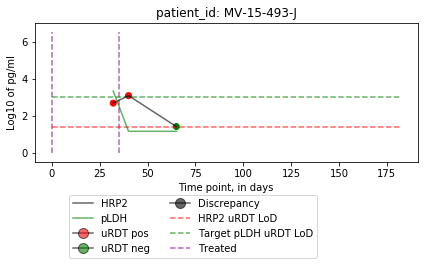

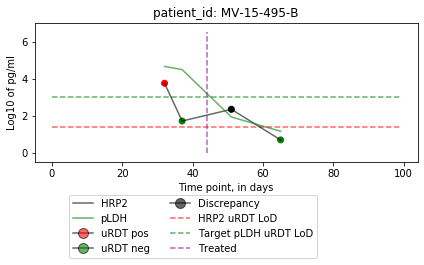

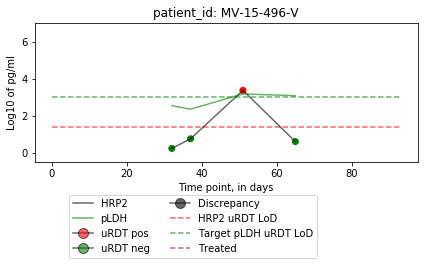

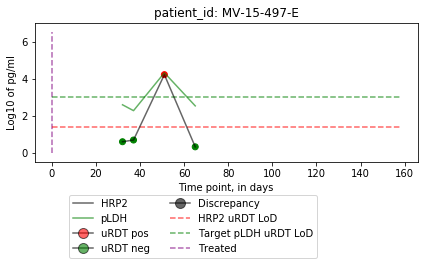

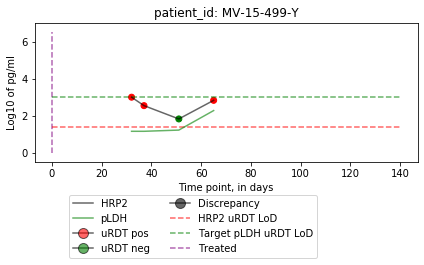

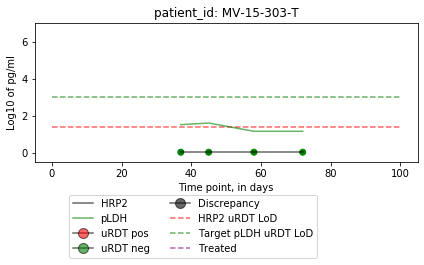

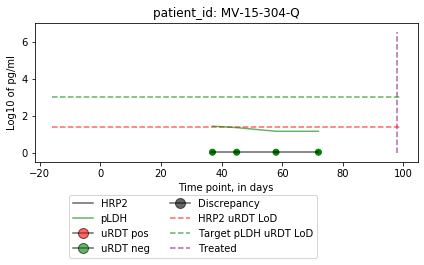

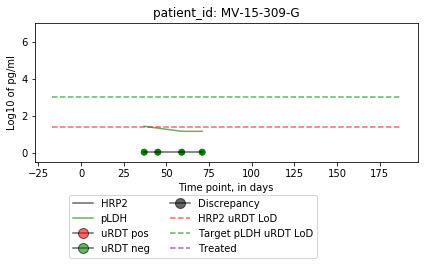

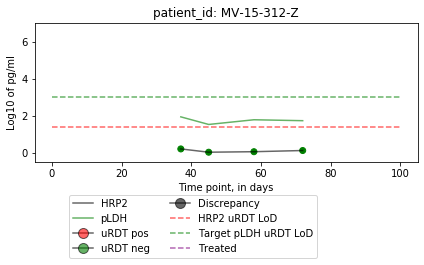

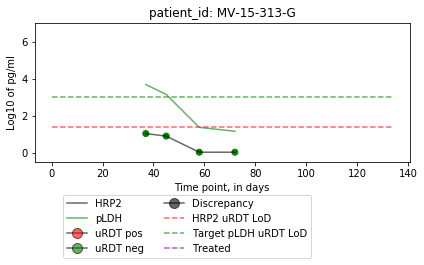

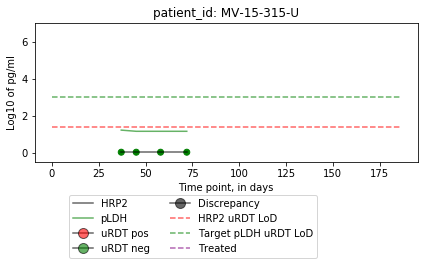

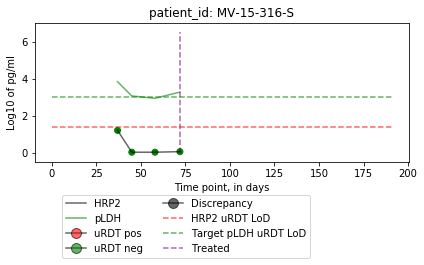

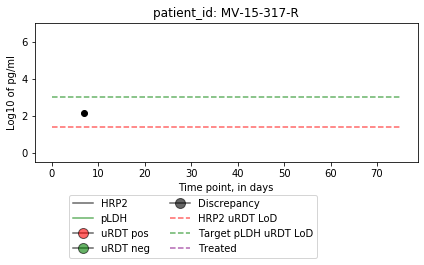

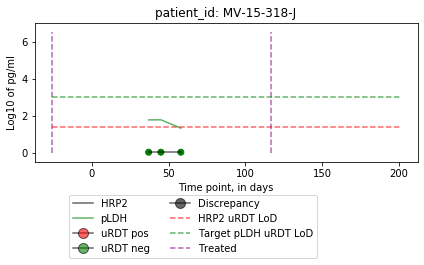

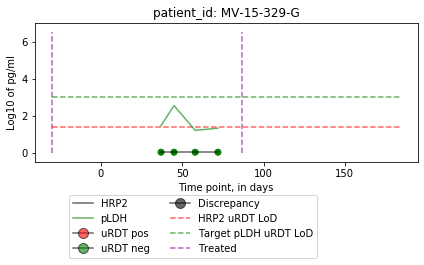

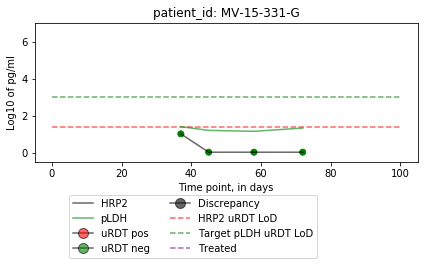

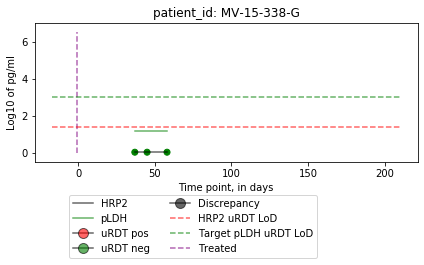

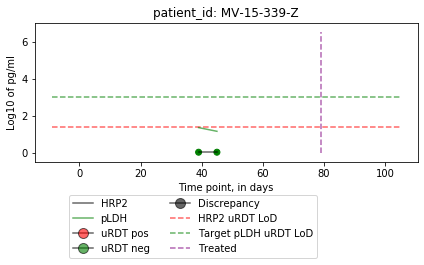

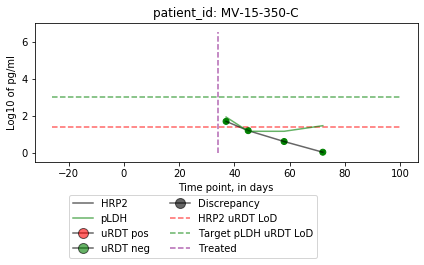

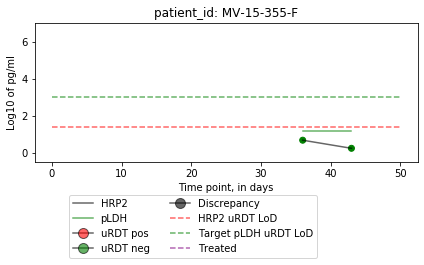

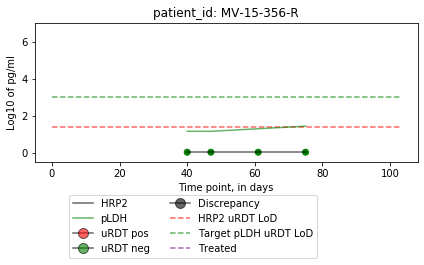

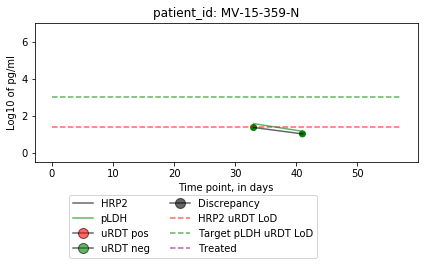

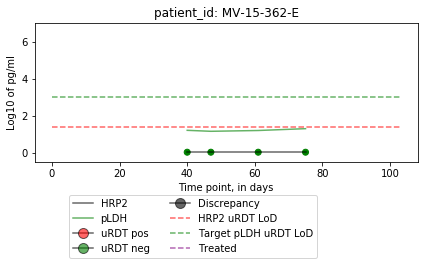

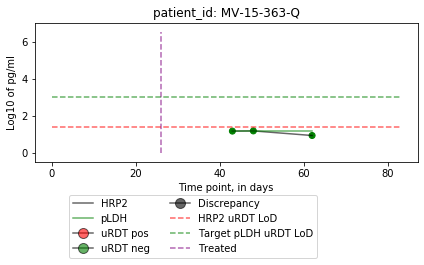

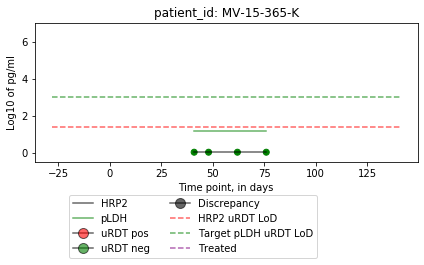

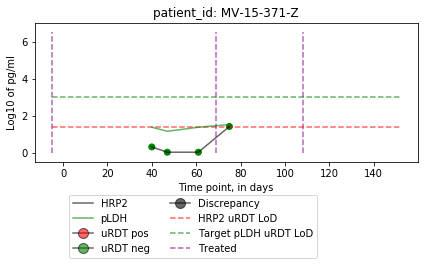

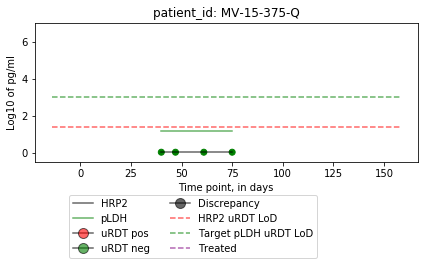

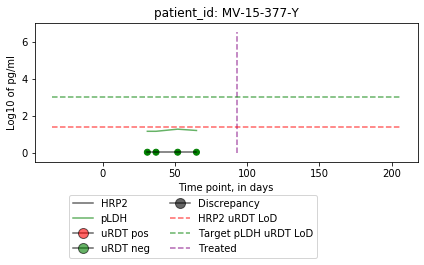

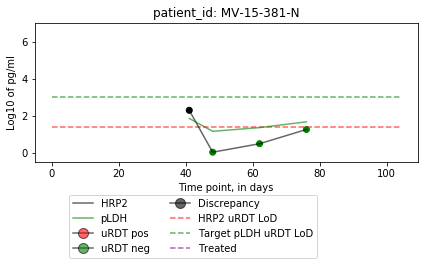

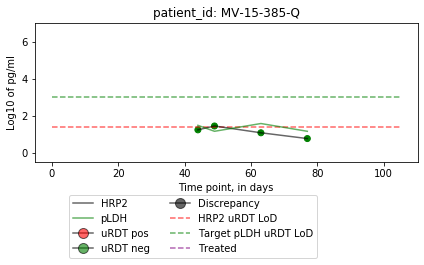

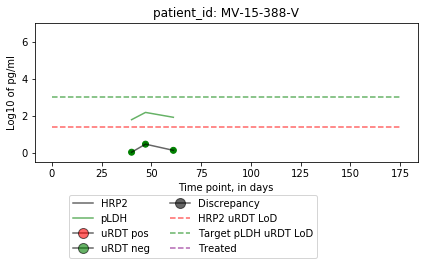

nan


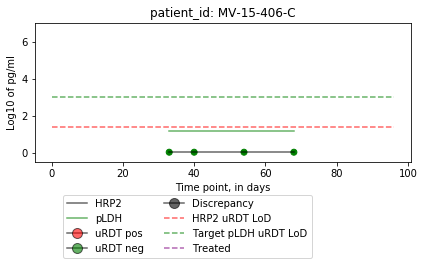

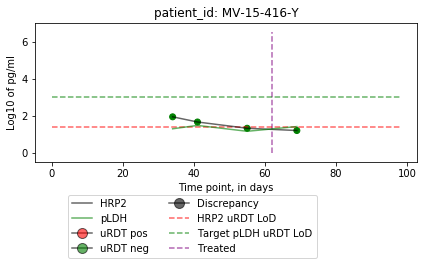

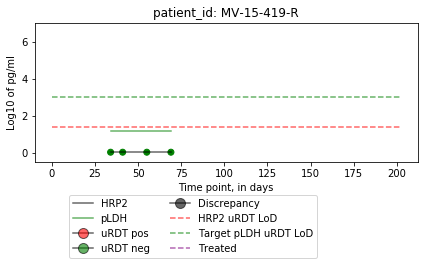

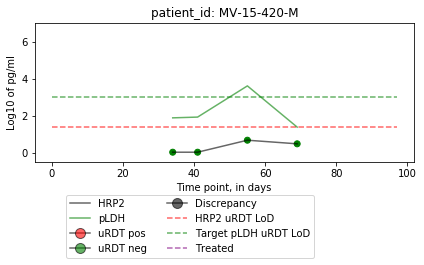

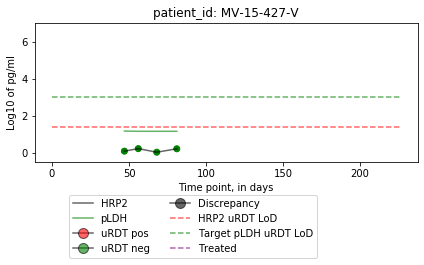

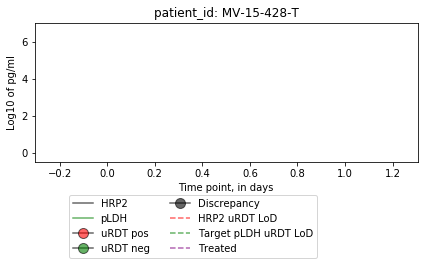

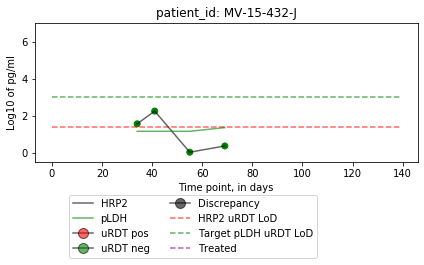

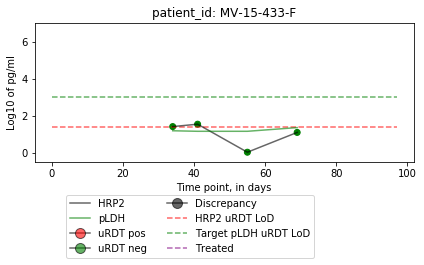

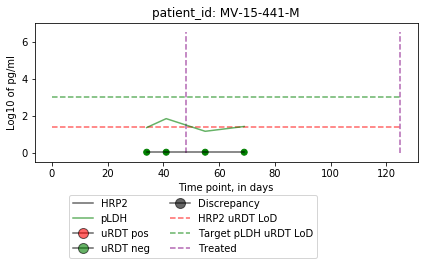

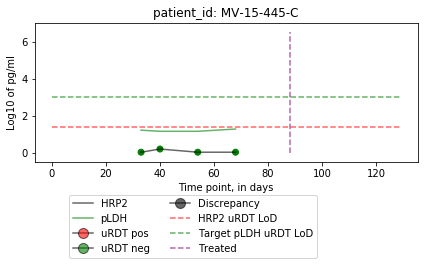

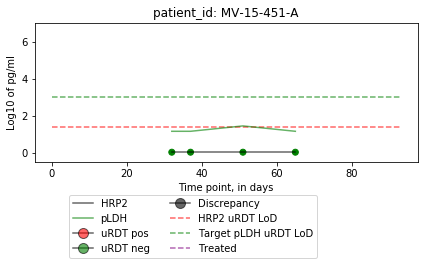

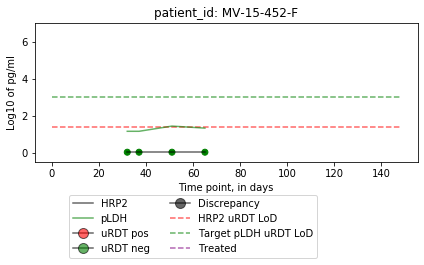

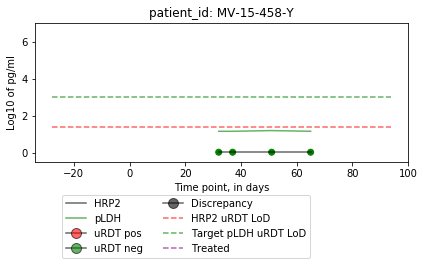

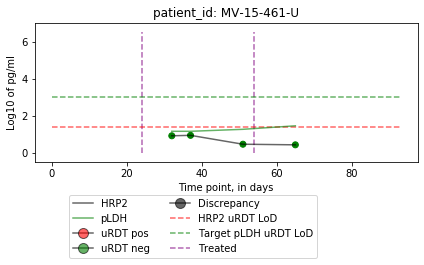

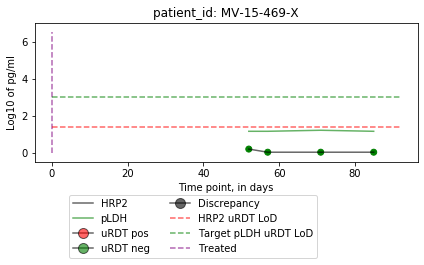

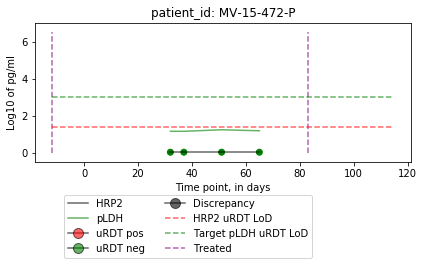

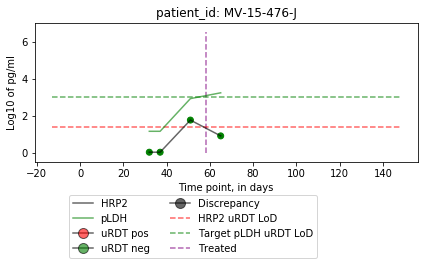

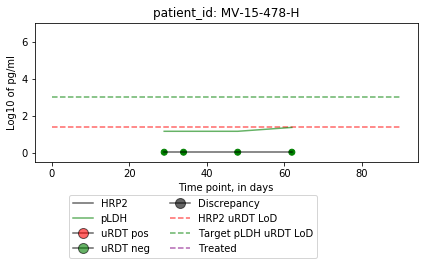

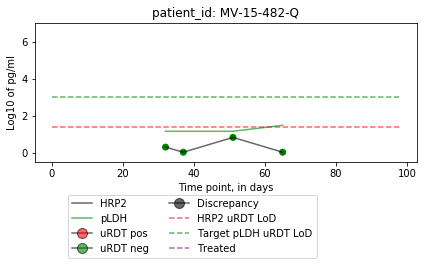

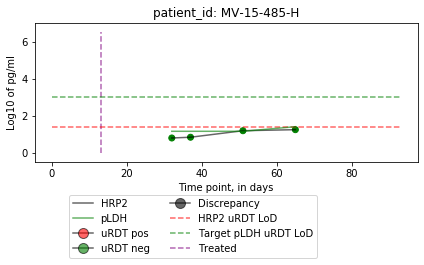

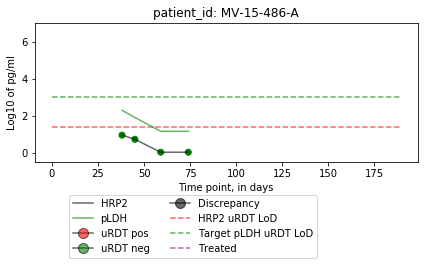

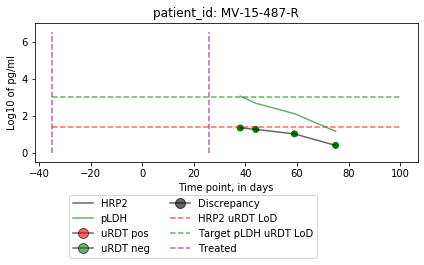

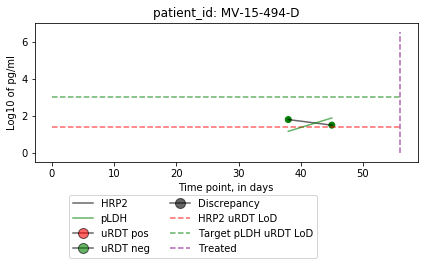

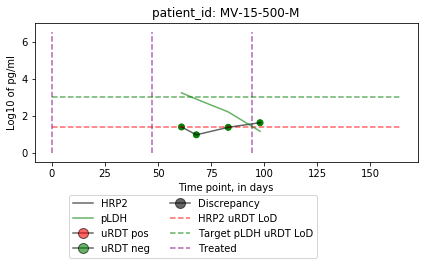

In [18]:
intro_pdf = PdfPages('C:/Users/lzoeckler/Desktop/mali_meta/NIH_mali_exploratory.pdf')
for pid in main_data['participant_id'].unique():
    combo = main_data.loc[main_data['participant_id'] == pid]
    if len(combo) > 0:
        combo = combo.sort_values('date_dif')
        for_line = combo.loc[~combo['HRP2_pg_ml'].isnull()]
        max_day = max(combo['date_dif'])
        min_day = min(combo['date_dif'])
        max_y = max([max(for_line['HRP2_pg_ml']), max(for_line['LDH_Pan_pg_ml'])])
        min_y = min([min(for_line['HRP2_pg_ml']), min(for_line['LDH_Pan_pg_ml'])])
        f, ax1 = plt.subplots()
        age = combo['age_yrs'].unique()[0]
        treatment_days = combo.loc[~combo['drug'].isnull(), 'date_dif'].tolist()
        for day in treatment_days:
            ax1.plot(np.array([day, day]), np.array([0, 6.5]), color='purple',
                     linestyle='--', alpha=0.6)
        hrp2_urdt_lod = ax1.plot(np.array([min_day, max_day]), np.array([1.4, 1.4]),
                                 color='red', linestyle='--', alpha=0.6)
        hrp2_urdt_lod = ax1.plot(np.array([min_day, max_day]), np.array([3, 3]),
                                 color='green', linestyle='--', alpha=0.6)
        title = """patient_id: {}""".format(pid)
        ln4 = ax1.plot(for_line['date_dif'], for_line['HRP2_pg_ml'],
                       c='black', alpha=0.6, label='HRP2')
        ln3 = ax1.plot(for_line['date_dif'], for_line['LDH_Pan_pg_ml'],
                       c='green', alpha=0.6, label='pLDH')
        ax1.scatter(for_line['date_dif'], for_line['HRP2_pg_ml'], c=for_line['RDT_pos'])
        ax1.set_title(title)
        ax1.set_xlabel('Time point, in days')
        ax1.set_ylabel('Log10 of pg/ml')
        ax1.set_ylim([-.5, 7])

        # LINE STUFF
        lns = ln4 + ln3
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='uRDT pos', markerfacecolor='r',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='uRDT neg', markerfacecolor='g',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Discrepancy', markerfacecolor='k',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='red', linestyle='--', label='HRP2 uRDT LoD', alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='green', linestyle='--', label='Target pLDH uRDT LoD', alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='purple', linestyle='--', label='Treated', alpha=0.6)]
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, bbox_to_anchor=(.75, -.2), ncol=2)

        # Actually plot stuff
        plt.tight_layout()
        intro_pdf.savefig(f)
        plt.show()
        plt.close()
    else:
        print(pid)
intro_pdf.close()